# Analysis of dataSet6

Instances consist of 3 feature: $a$, $b$, $c$. The goal is to define clusters and develop a predicitve model for these clusters.

In [1]:
### Import packages for data analysis
import os    # OS module provides the interface with the operating system and allows to use it
import tarfile
from six.moves import urllib
import pandas as pd     # Pandas: python library for large data manipulation and analysis. 
                        # Dataset will be saved as Pands dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

%matplotlib inline

# disable warnings
import warnings
warnings.filterwarnings("ignore")


### Acquire dataset
data_path='C:/Users/jacopo/Desktop/schaeffler/testData6.csv'
dataset = pd.read_csv(data_path,sep=';')   # dataset as pandas dataset


## Part 1: Visualization and descriptive statistics of the dataset

The goal of this analysis is to get some insights on the data and eventually spot the presence of clusters. 

The dataset consists of 5000 instances with **numerical continuous features**. 

The dataset is also **complete**, no NaN were found. 

Features have the **same order of magnitude**. Means and standard deviation are close to each others.

In [2]:
print('Overview of the dataset: size of dataset and type of data:\n')
dataset.info()

print('\nDescriptive statistics of the dataset:')
dataset.describe()

Overview of the dataset: size of dataset and type of data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
a    5000 non-null float64
b    5000 non-null float64
c    5000 non-null float64
dtypes: float64(3)
memory usage: 117.3 KB

Descriptive statistics of the dataset:


,a,b,c
count,5000.000000,5000.000000,5000.000000
mean,-165.730680,-173.661186,-151.365124
std,4196.018485,4168.445734,4289.631511
min,-7902.340000,-7585.190000,-8330.840000
25%,-2923.310000,-2943.562500,-3347.752500
50%,-3.675000,-3.060000,68.615000
75%,3269.232500,3025.977500,3012.525000
max,6861.640000,7511.560000,10229.370000


(-11000, 13000)

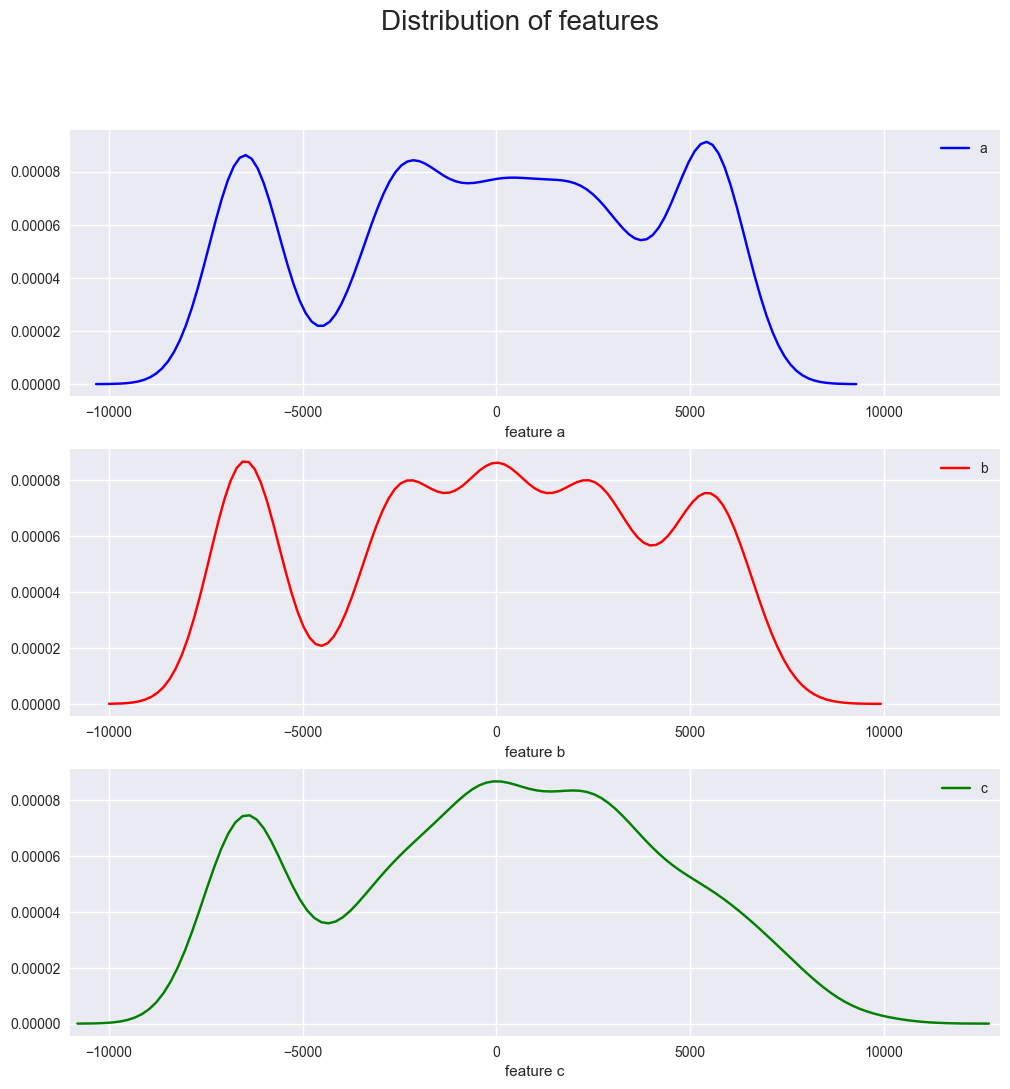

In [3]:
# Create a figure instance, and the two subplots

x_range = [-11000, 13000]

fig = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of features',fontsize=20)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


# Plot distribution of feature a
sns.kdeplot(dataset['a'],color='b', ax = ax1)
ax1.set_xlabel('feature a')
ax1.set_xlim(x_range)

# Plot distribution of feature b
sns.kdeplot(dataset['b'],color='r', ax = ax2)
ax2.set_xlabel('feature b')
ax2.set_xlim(x_range)

# Plot distribution of feature c
sns.kdeplot(dataset['c'],color='g', ax = ax3)
ax3.set_xlabel('feature c')
ax3.set_xlim(x_range)



From the analysis of the distributions, we can clearly distinguish **peaks in the distribution curves** of the features. This indicates the **presence of clusters**. 

In particular, it is possible to distinguish two peaks for $c$ (bimodal distribution) and two peaks plus a flat peak central region for the features $a$ and $b$. Notably for the feature $b$, the central region presents 3 small peaks. Therefore, the presence of these peaks confirm the presence of clusters of data. Since two distributions present three clear 'peaks', it is reasonable to expect *three clusters*. 

Since we have three features, we can generate 3D scatter plots. 

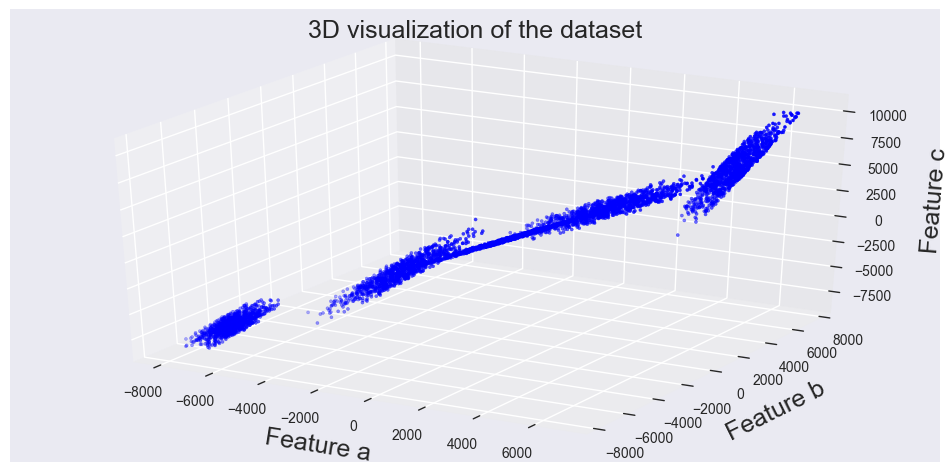

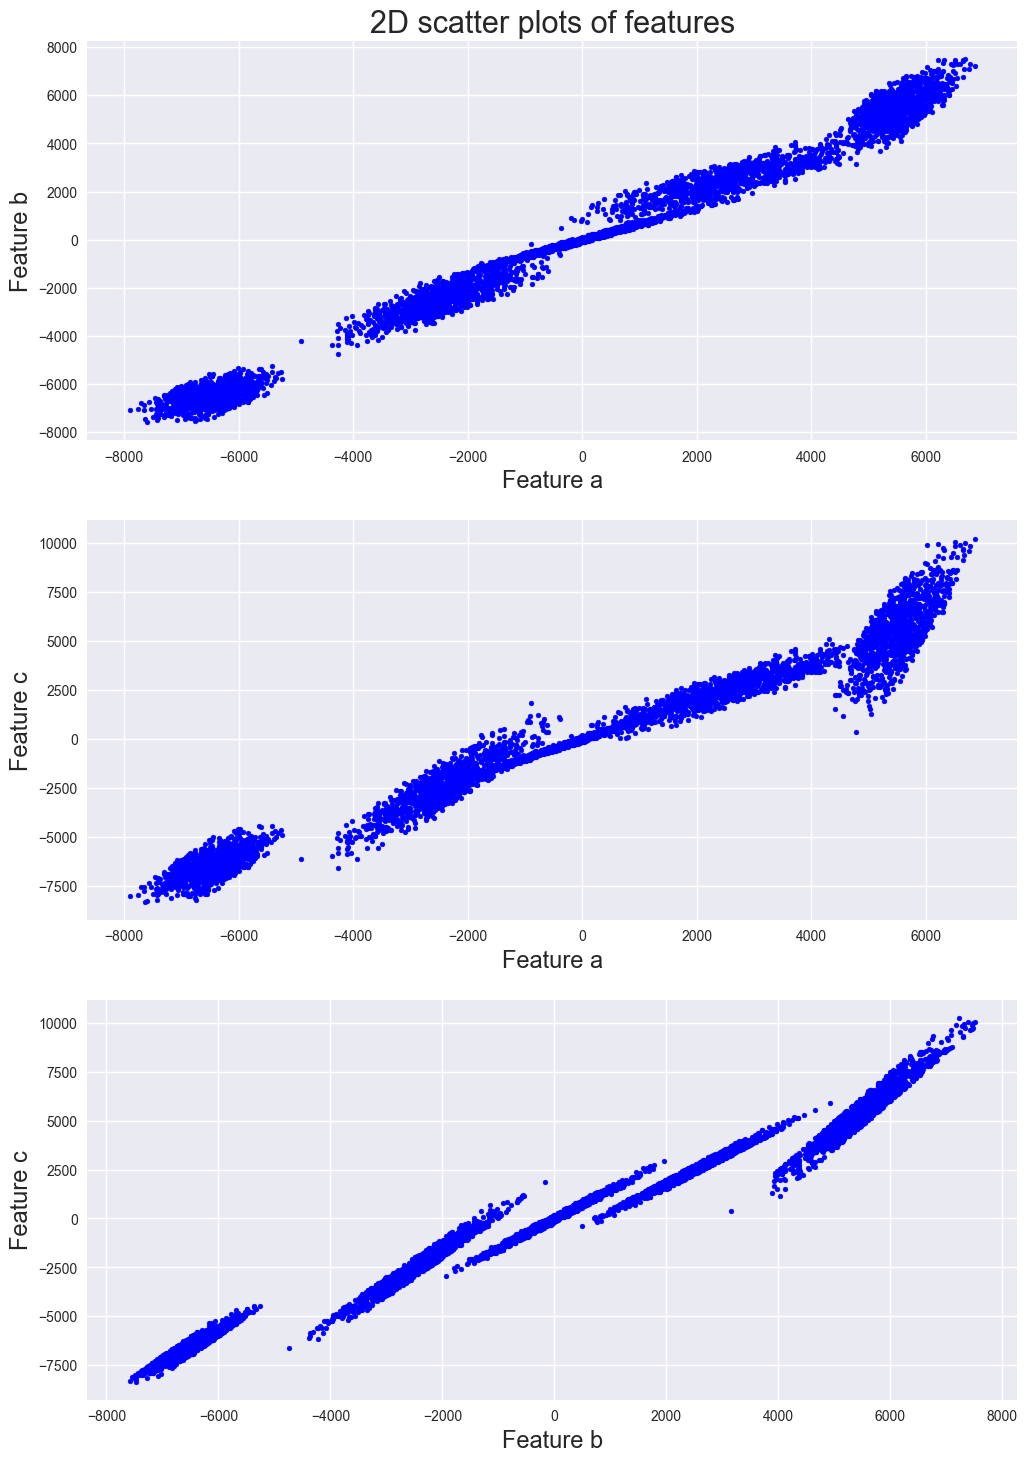

In [4]:
# 3D plot
fig = plt.figure(num=None, figsize=(12, 6), dpi=100,facecolor='w',edgecolor='k')

ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset['a'],dataset['b'],dataset['c'], c='b', marker='.')

ax.set_xlabel('Feature a',fontsize=18,labelpad=15)
ax.set_ylabel('Feature b',fontsize=18,labelpad=15)
ax.set_zlabel('Feature c',fontsize=18,labelpad=15)

plt.title('3D visualization of the dataset',fontsize=18)

plt.show()



# 2D scatterplot of features
fontS = 17
f, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False, sharey=False, dpi=100, facecolor='w', edgecolor='k')

# Plot 1: a-b
axes[0].scatter(dataset['a'],dataset['b'], c='b', marker='.')
axes[0].set_xlabel('Feature a',fontsize=fontS)
axes[0].set_ylabel('Feature b',fontsize=fontS)
axes[0].set_title('2D scatter plots of features',fontsize=22)

# Plot 2: a-c
axes[1].scatter(dataset['a'],dataset['c'], c='b', marker='.')
axes[1].set_xlabel('Feature a',fontsize=fontS)
axes[1].set_ylabel('Feature c',fontsize=fontS)

# Plot 3: b-c
axes[2].scatter(dataset['b'],dataset['c'], c='b', marker='.')
axes[2].set_xlabel('Feature b',fontsize=fontS)
axes[2].set_ylabel('Feature c',fontsize=fontS)

plt.show()

From the previous scatter plots it is possible to observe three clear clusters of data (3D plot). However, from the plot $(b,c)$, we can clearly distinguish 5 clusters of data. 

In addition, it is possible to observe that data are distributed along a specific direction (diagonal of each scatter plot), which is the direction of maximum variance. Therefore, we analyze the principal components of these data using PCA.

variance along the principal xes:
[ 0.99323697  0.00536376]


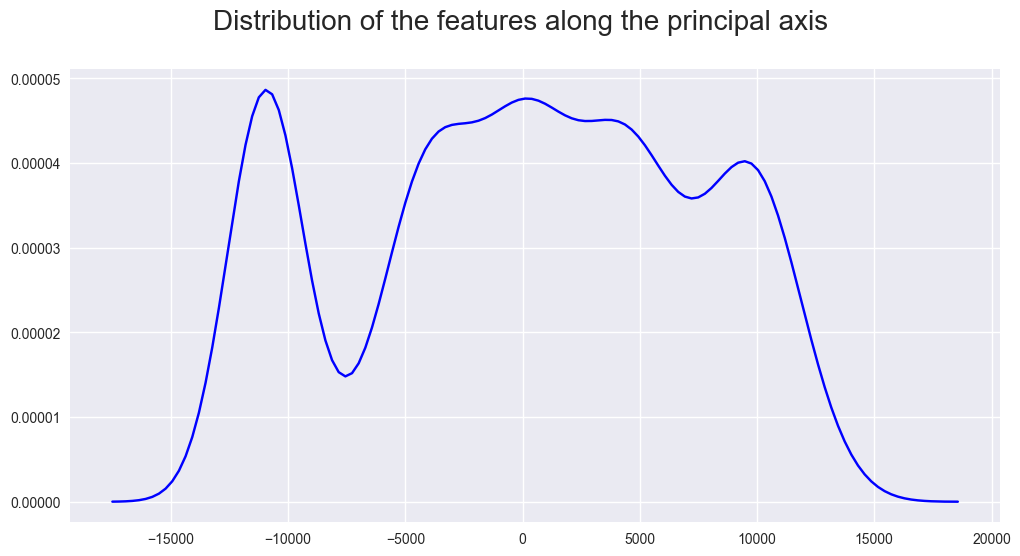

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2).fit(dataset)

print('variance along the principal axes:')
print(pca.explained_variance_ratio_)

data_transformed = pca.transform(dataset)

# Plot distribution of transformed data
fig = plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
fig.suptitle('Distribution of the features along the principal axis',fontsize=20)

sns.kdeplot(data_transformed[:,0],color='b')


The Principal Component Analysis shows that the distribution of features on the principal axis presents on clear peak at about -11000, a second peak at around 0 and a third peak at around 10000. This analysis confirms the **presence of two or three clusters of data**. It is necessary to remember that when data are projected on the principal axis, some information are lost (loss proportional to the distance to the principal axis). Therefore, the third peak at 10000 may be more distinguished as in the 2D scatter plots previously described.

## Part 2: Data clustering via DBSCAN

We now apply DBSCAN to cluster data. The reason of the choice of thi method is that we have observed the presence of 2-3 clusters, which do not have spherical shape. 


In [6]:
# Function for plotting distribution of features in each cluster

def distribution_features_cluster(C_1,C_2,C_3,C_4,C_5):
    fig = plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    # Plot distribution of feature a
    attr = 0
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax1)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax1)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax1)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax1)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax1)
    ax1.set_title('feature a')




    # Plot distribution of feature b
    attr = 1
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax2)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax2)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax2)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax2)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax2)
    ax2.set_title('feature b')



    # Plot distribution of feature c
    attr = 2
    sns.kdeplot(C_1[attr],label="C_1",color='b', ax = ax3)
    sns.kdeplot(C_2[attr],label="C_2",color='r', ax = ax3)
    if np.shape(C_3)[0]>0:
        sns.kdeplot(C_3[attr],label="C_3",color='g', ax = ax3)
    if np.shape(C_4)[0]>0:
        sns.kdeplot(C_4[attr],label="C_4",color='y', ax = ax3)
    if np.shape(C_5)[0]>0:
        sns.kdeplot(C_5[attr],label="C_5",color='k', ax = ax3)
    ax3.set_title('feature c')


    plt.show()
    

    # Labeled 3D plot
    fig = plt.figure(num=None, figsize=(12, 6), dpi=100,facecolor='w',edgecolor='k')

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(C_1[:,0],C_1[:,1],C_1[:,2], c='b', marker='.',label="C_1")
    ax.scatter(C_2[:,0],C_2[:,1],C_2[:,2], c='r', marker='.',label="C_2")
    ax.scatter(C_3[:,0],C_3[:,1],C_3[:,2], c='g', marker='.',label="C_3")
    ax.scatter(C_4[:,0],C_4[:,1],C_4[:,2], c='y', marker='.',label="C_4")
    ax.scatter(C_5[:,0],C_5[:,1],C_5[:,2], c='k', marker='.',label="C_5")

    ax.set_xlabel('Feature a',fontsize=18,labelpad=15)
    ax.set_ylabel('Feature b',fontsize=18,labelpad=15)
    ax.set_zlabel('Feature c',fontsize=18,labelpad=15)

    plt.title('3D visualization of clustered data',fontsize=18)
    plt.legend()

    plt.show()

Before applying DBSCAN, we scale the features using scikit-learn's Min-Max scaler

In [7]:
# scaling of data before using DBSCAN
from sklearn.preprocessing import MinMaxScaler

scaler_Feature = MinMaxScaler().fit(dataset)

dataset_scaled = scaler_Feature.transform(dataset)
A_scaled = dataset_scaled[:,0]
B_scaled = dataset_scaled[:,1]
C_scaled = dataset_scaled[:,2]

DBSCAN has three important hyperparameters:
1. eps: maximum distance from a core point

2. minP: minimum number of points that define a cluster

3. Definition of how to compute distance between points

By changing $eps$, we can detect different clusters. We tried the following values:

- eps = 0.026: 5 clusters detected

- eps = 0.03: 3 clusters detected

- eps = 0.05: 2 clusters detected

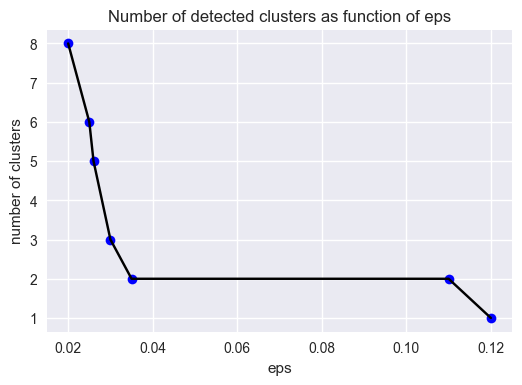

In [8]:
eps = [0.02, 0.025, 0.026, 0.03, 0.035, 0.11, 0.12]
cls = [8, 6, 5, 3, 2,2,1]
plt.figure(num=None, figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k')
plt.plot(eps, cls, 'bo', eps, cls, 'k')
plt.xlabel('eps')
plt.ylabel('number of clusters')
plt.title('Number of detected clusters as function of eps')
plt.show()

Number of detected clusters (eps = 0.026):
5


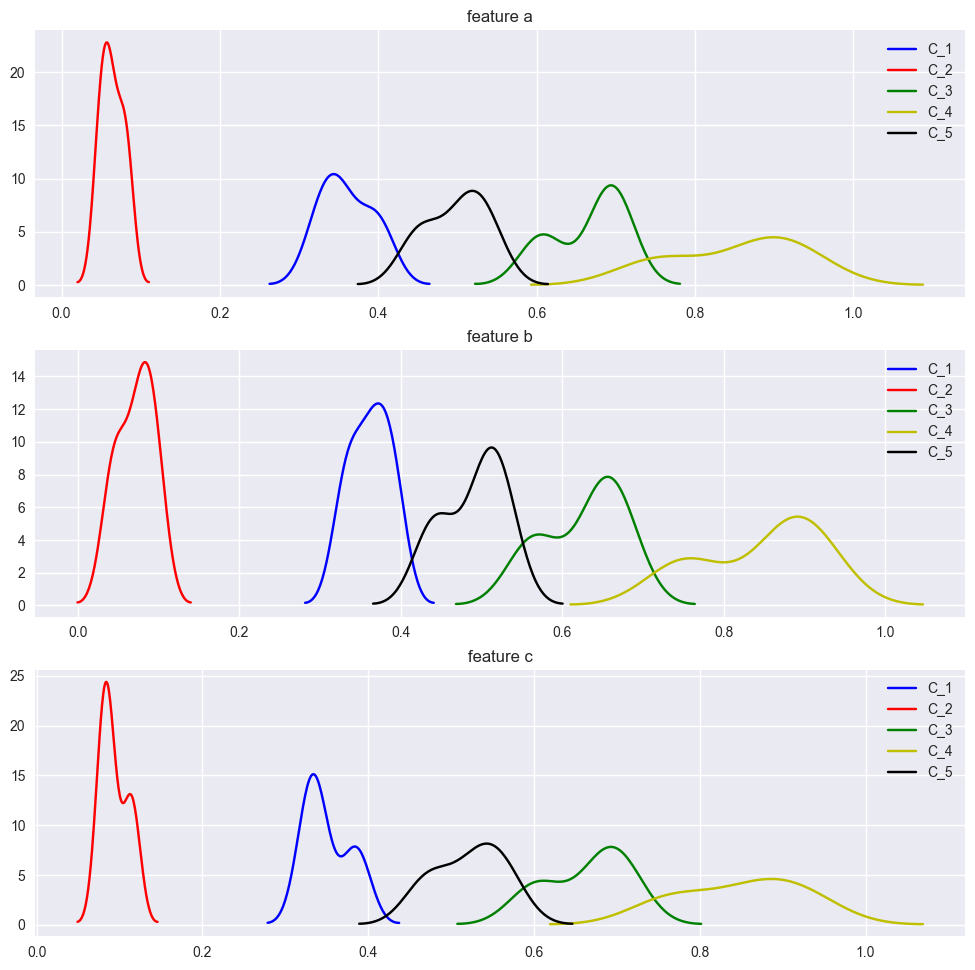

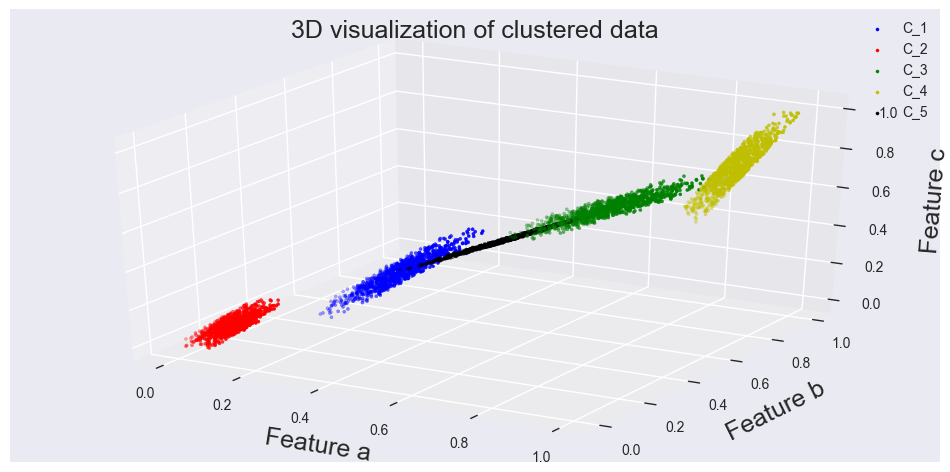

In [9]:
# Application of DBscan with eps = 0.026
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.026, 
            min_samples=5, 
            metric='euclidean', 
            algorithm='auto', 
            p=None, 
            n_jobs=1)

db.fit(dataset_scaled)
labels = db.labels_   # each element is assigned to a number according to the cluster 

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Number of detected clusters (eps = 0.026):')
print(n_clusters_)

# Get clusters: create a new numpy array for each cluster
C1_5= dataset_scaled[np.where(labels == 0)]
C2_5 = dataset_scaled[np.where(labels == 1)]
C3_5 = dataset_scaled[np.where(labels == 2)]
C4_5 = dataset_scaled[np.where(labels == 3)]
C5_5 = dataset_scaled[np.where(labels == 4)]

distribution_features_cluster(C1_5,C2_5,C3_5,C4_5,C5_5)

Number of detected clusters (eps = 0.03):
3


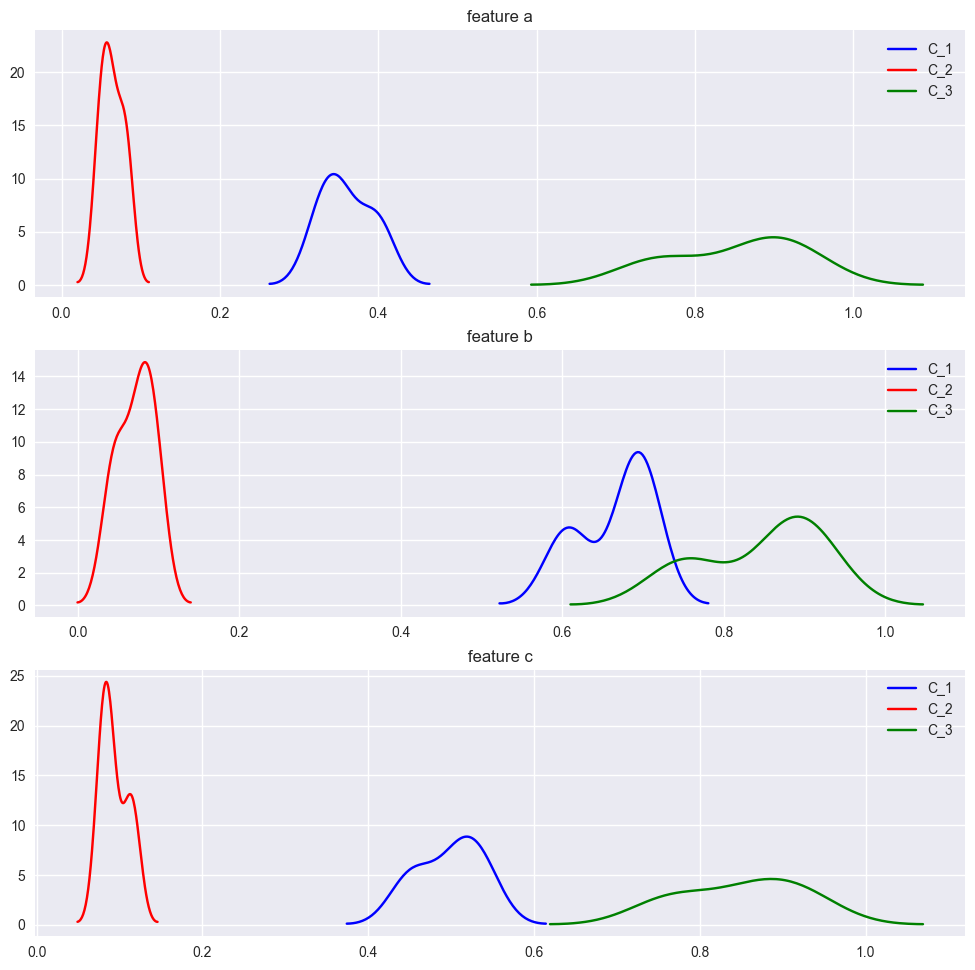

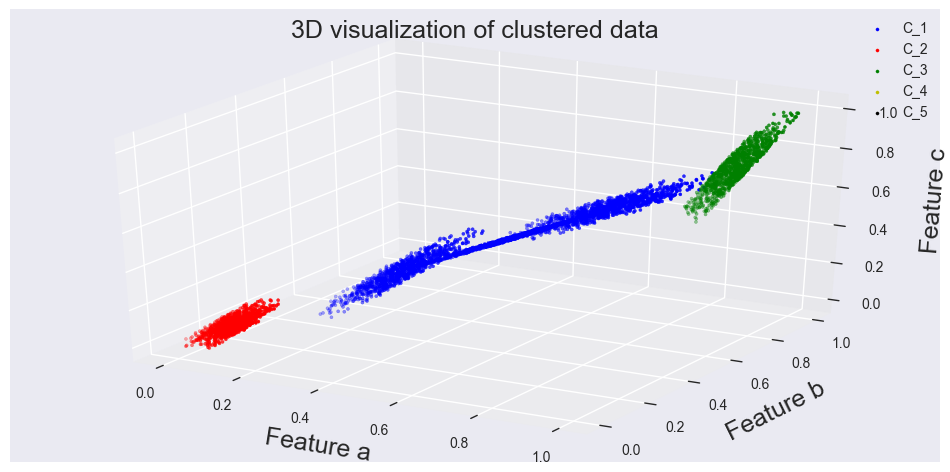

In [10]:
# Application of DBscan with eps = 0.03
db = DBSCAN(eps=0.03, 
            min_samples=5, 
            metric='euclidean', 
            algorithm='auto', 
            p=None, 
            n_jobs=1)

db.fit(dataset_scaled)
labels = db.labels_   # each element is assigned to a number according to the cluster 

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Number of detected clusters (eps = 0.03):')
print(n_clusters_)

# Get clusters: create a new numpy array for each cluster
C1_3 = dataset_scaled[np.where(labels == 0)]
C2_3 = dataset_scaled[np.where(labels == 1)]
C3_3 = dataset_scaled[np.where(labels == 2)]
C4_3 = dataset_scaled[np.where(labels == 3)]
C5_3 = dataset_scaled[np.where(labels == 4)]

distribution_features_cluster(C1_3,C2_3,C3_3,C4_3,C5_3)

Number of detected clusters (eps = 0.05):
2


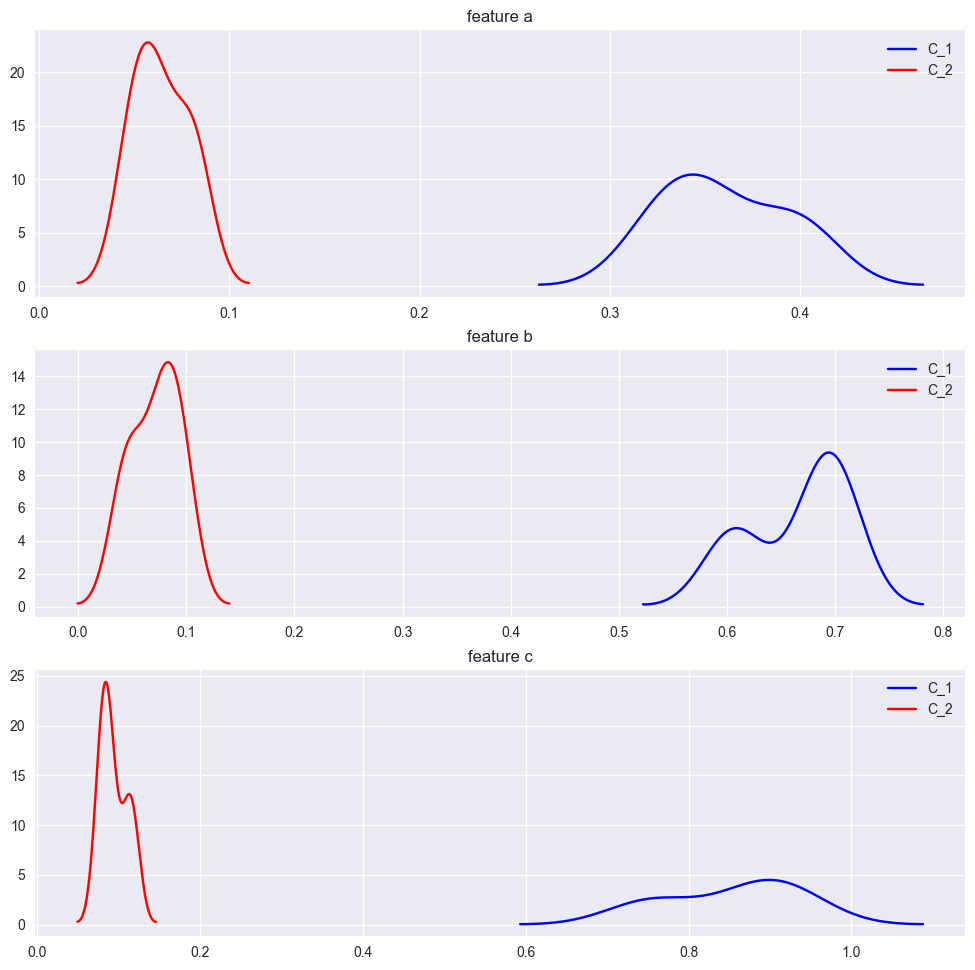

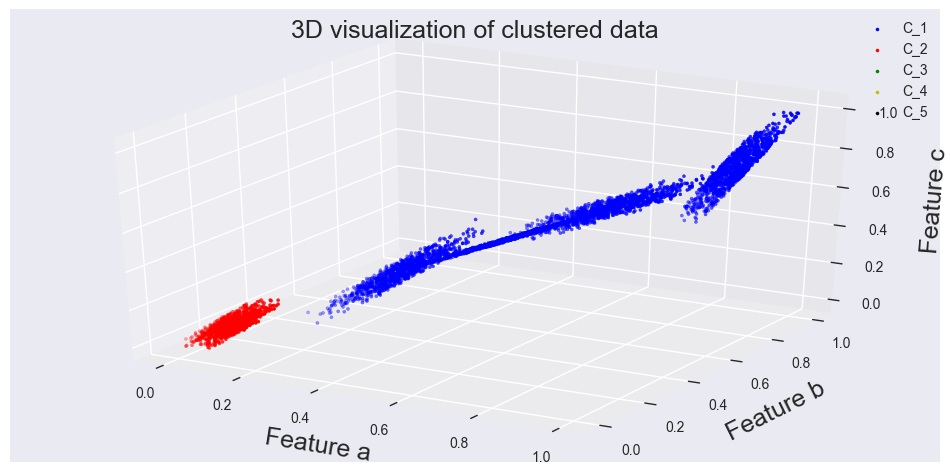

In [11]:
# Application of DBscan with eps = 0.05
db = DBSCAN(eps=0.05, 
            min_samples=5, 
            metric='euclidean', 
            algorithm='auto', 
            p=None, 
            n_jobs=1)

db.fit(dataset_scaled)
labels = db.labels_   # each element is assigned to a number according to the cluster 

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Number of detected clusters (eps = 0.05):')
print(n_clusters_)

# Get clusters: create a new numpy array for each cluster
C1_2 = dataset_scaled[np.where(labels == 0)]
C2_2 = dataset_scaled[np.where(labels == 1)]
C3_2 = dataset_scaled[np.where(labels == 2)]
C4_2 = dataset_scaled[np.where(labels == 3)]
C5_2 = dataset_scaled[np.where(labels == 4)]

distribution_features_cluster(C1_2,C2_2,C3_2,C4_2,C5_2)

The cluster detection shows that 2 clusters can be clearly detected using larger eps. In this case, all the three features are clearly distinguished since the distribution in each clusters do not overlap.

By decreasing eps, 3 clusters can be detected. In these case, the features $a$ and $c$ are clearly separated, whereas the distributions of feature $b$ of cluster 2 and 3 slightly overlap.

With low eps, 5 clusters are detected, but the distributions of each feature for clusters 2,3,4,5 overlap.

## Part 3: Machine Learning model for cluster prediction

A machine learning model is now built for predicting the cluster of new data points.

We select **three clusters**, therefore we will solve a **multilabel classification problem**.

The first step is to assign the cluster identification number to each point of the dataset. Than training and test datasets will be generated.

In [12]:
### Label original data according to the cluster

# Cluster: 1
N_1 = np.shape(C1_3)[0]
data_cluster_1 = np.ones((N_1,4))*0
data_cluster_1[:,:-1] = C1_3

# Cluster: 2
N_2 = np.shape(C2_3)[0]
data_cluster_2 = np.ones((N_2,4))*1
data_cluster_2[:,:-1] = C2_3

# Cluster: 3
N_3 = np.shape(C3_3)[0]
data_cluster_3 = np.ones((N_3,4))*2
data_cluster_3[:,:-1] = C3_3


# labeled dataset
dataset_labeled = np.concatenate((data_cluster_1,data_cluster_2,data_cluster_3),axis=0)

Population of each cluster


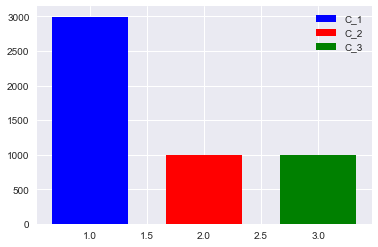

In [18]:
# Population of each cluster
print('Population of each cluster')

y = [N_1, N_2, N_3]
x = [0, 1, 2]
width = 1/1.5

fig = plt.gcf()
plt.bar(1, N_1, width, color="b", label='C_1')
plt.bar(2, N_2, width, color="r", label='C_2')
plt.bar(3, N_3, width, color="g", label='C_3')

plt.legend()


In [62]:
# Split dataset into training and test
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix


Features_X = dataset_labeled[:,0:3]
Label_Y = dataset_labeled[:,3]
train_Features, test_Features, train_Label, test_Label = train_test_split(Features_X, 
                                                                            Label_Y, 
                                                                            test_size=0.2,
                                                                            random_state=42)

print(len(train_Features), "train +", len(test_Features), "test")

3994 train + 999 test


At this point, it is important to note that the label contains the numbers 1,2,3 representing a specific cluster each. Therefore, these are categorical values and must be converted into numerical using an encoding procedure. For this tast, we use Pandas' get_dummies function.

In [59]:
train_Label_encoded = pd.get_dummies(train_Label).values
test_Label_encoded = pd.get_dummies(test_Label).values

At this point, data are ready for training a Machine Learning algorithm for multiclass classification.

- kNN classifier

- Random forest classifier

- Naive Bayes Gaussian

- Logistic regression (One vs. All)

Scoring is f1_macro

In [77]:
from sklearn.neighbors import KNeighborsClassifier

kNN_clf = KNeighborsClassifier().fit(train_Features, train_Label_encoded)

Label_prediction = kNN_clf.predict(train_Features)


np.mean(cross_val_score(kNN_clf, train_Features, train_Label_encoded, cv=10, scoring='f1_macro'))


#y_train_pred = cross_val_predict(RanForest_clf, train_Features, train_Label_encoded, cv=10)
#conf_mx = confusion_matrix(train_Label, y_train_pred)

#plt.matshow(conf_mx, cmap=plt.cm.gray)
#plt.show()

1.0

In [78]:
from sklearn.ensemble import RandomForestClassifier

RanForest_clf = RandomForestClassifier().fit(train_Features, train_Label_encoded)

Label_prediction = RanForest_clf.predict(train_Features)

np.mean(cross_val_score(RanForest_clf, train_Features, train_Label_encoded, cv=10, scoring='f1_macro'))


0.99891003069200246

In [83]:
from sklearn.naive_bayes import GaussianNB

gNB_clf = GaussianNB().fit(train_Features, train_Label)

Label_prediction = gNB_clf.predict(train_Features)

np.mean(cross_val_score(gNB_clf, train_Features, train_Label, cv=10, scoring='f1_macro'))

0.25023498707325803

In [82]:
from sklearn.linear_model import LogisticRegressionCV 

LogReg_clf = LogisticRegressionCV(multi_class='ovr')
LogReg_clf.fit(train_Features, train_Label)

Label_prediction = LogReg_clf.predict(train_Features)

np.mean(cross_val_score(LogReg_clf, train_Features, train_Label, cv=10, scoring='f1_macro'))

0.99972366059322582

In [ ]:
# LogisticReg